In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import pywt
import pywt.data
from filterpy.kalman import KalmanFilter
from numpy import array, asarray
import pycwt as wavelet
from pycwt.helpers import find
from matplotlib import pyplot
import math
from filterpy.common import pretty_str, reshape_z
import torch
from sklearn import preprocessing
from tqdm import tqdm
import time
from torch.autograd import Variable
from scipy.optimize import minimize
import time

## 整数倍部分

In [2]:
# x = Fx + Bw
# z = Hx + v
class Kalman(object):
    def __init__(self, dim_x, dim_z, dim_u=0):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = np.zeros((dim_x, 1))        # state
        self.P = np.eye(dim_x)*0.1               # uncertainty covariance
        self.Q = np.eye(dim_x)               # process uncertainty
        self.Q_w = np.eye(dim_x)
        self.B = None                     # noise transition matrix
        self.F = np.eye(dim_x)               # state transition matrix
        self.f = np.eye(dim_x)
        self.H = np.zeros((dim_z, dim_x))    # measurement function
        self.R = np.eye(dim_z)               # measurement uncertainty
        self._alpha_sq = 1.               # fading memory control
#         self.M = np.zeros((dim_x, 1)) # process-measurement cross correlation
        self.w = np.zeros((dim_x, 1))
        self.z = np.array([[None]*self.dim_z]).T
        self.Psi = None
        self.n = 0
        # gain and residual are computed during the innovation step. We
        # save them so that in case you want to inspect them for various
        # purposes
        self.K = np.zeros((dim_x, dim_z)) # kalman gain
        self.L = np.zeros((dim_x, dim_z))
        self.y = np.zeros((dim_z, 1))
        self.S = np.zeros((dim_z, dim_z)) # system uncertainty
        self.SI = np.zeros((dim_z, dim_z)) # inverse system uncertainty
        self.I_KH = np.zeros((dim_x, dim_x))

        # identity matrix. Do not alter this.
        self._I = np.eye(dim_x)
        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
        
        self.inv = np.linalg.inv
    def predict(self, B=None, H=None, F=None, Q=None):
        if B is None:
            B = self.B
        if H is None:
            H = self.H
        if F is None:
            F = self.F
        if Q is None:
            Q = self.Q
            
        # x_ = Fx_ + Ly
        self.x = np.dot(F, self.x)
        # P_ = FPF' + BQB'
        self.P = np.dot(F,np.dot(self.P,F.T)) + B@Q@B.T
    def update(self, z, R=None, H=None):
        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            self.y = zeros((self.dim_z, 1))
            return

        if R is None:
            R = self.R

        if H is None:
            z = reshape_z(z, self.dim_z, self.x.ndim)
            H = self.H

        # y = z - Hx
        # error (residual) between measurement and prediction
        self.y = z - np.dot(H, self.x)

        # common subexpression for speed
        PHT = np.dot(self.P, H.T)

        # S = HPH' + R
        # project system uncertainty into measurement space
        self.S = np.dot(H, PHT) + R
        self.SI = self.inv(self.S)
        # K = PH'inv(S)
        # map system uncertainty into kalman gain
        self.K = np.dot(PHT, self.SI)

        # x = x + Ky
        # predict new x with residual scaled by the kalman gain
        self.x = self.x + np.dot(self.K, self.y)

        # P = (I-KH)P(I-KH)' + KRK'
        # This is more numerically stable
        # and works for non-optimal K vs the equation
        # P = (I-KH)P usually seen in the literature.

        self.I_KH = self._I - np.dot(self.K, H)
        self.P = self.P - np.dot(np.dot(self.K, self.S), self.K.T)
#         print(I_KH,'---')
        # save measurement and posterior state
#         self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
def matrixPow(Matrix,n):
    if(type(Matrix)==list):
        Matrix=np.array(Matrix)
    if(n==0):
        return np.eye(Matrix.shape[0])
    elif(n==1):
        return Matrix
    else:
        return np.matmul(Matrix,matrixPow(Matrix,n-1))
# 预处理函数
def pretreatment(x,ma,mi,l):
    hatx = np.zeros((1,l))
#     print(hatx[0,:])
    for i in range(l):
        hatx[0,i] = (x[i]-mi)/(ma-mi)
#     print(hatx)
    return hatx
# 预处理函数
def normalization_2(x1,x2,y):
    h1 = len(x1)
    h2 = len(x2)
    l = len(y)
    C=np.zeros((1,2))
    M1=np.zeros((1,h1))
    M2=np.zeros((1,h2))
    N=np.zeros((1,l))
    Max=x1[0]
    Min=x1[0]
    for i in range(h1):
        if x1[i] > Max:
            Max = x1[i]
        elif x1[i] < Min:
            Min = x1[i]
        else:
            pass
    for i in range(h2):
        if x2[i] > Max:
            Max = x2[i]
        elif x2[i] < Min:
            Min = x2[i]
        else:
            pass
    C = [Max,Min]
    M1 = pretreatment(x1,Max,Min,h1)
    M2 = pretreatment(x2,Max,Min,h2)
    N = pretreatment(y,Max,Min,l)
    
    return (M1,M2,N,C)
# 定义normalization函数
def normalization_3(x0,x1,x2,y):
#     (x_h,x_l) = x.shape
#     (y_h,y_l) = y.shape
    h0 = len(x0)
    h1 = len(x1)
    h2 = len(x2)
    l = len(y)
    C=np.zeros((1,2))
    M0=np.zeros((1,h0)) # x0归一化后
    M1=np.zeros((1,h1)) # x1归一化后
    M2=np.zeros((1,h2)) # x2归一化后
    N=np.zeros((1,l)) # y归一化后
    Max=x0[0]
    Min=x0[0]
    for i in range(h0):
        if x0[i] > Max:
            Max = x0[i]
        elif x0[i] < Min:
            Min = x0[i]
        else:
            pass
    for i in range(h1):
        if x1[i] > Max:
            Max = x1[i]
        elif x1[i] < Min:
            Min = x1[i]
        else:
            pass
    for i in range(h2):
        if x2[i] > Max:
            Max = x2[i]
        elif x2[i] < Min:
            Min = x2[i]
        else:
            pass
    C = np.array([[Max,Min]])
    M0 = pretreatment(x0,Max,Min,h0)
    M1 = pretreatment(x1,Max,Min,h1)
    M2 = pretreatment(x2,Max,Min,h2)
#         N[i] = pretreatment(y[i],Max,Min,1)
#     for j in range(l):
    N = pretreatment(y,Max,Min,l)
#     print([Max,Min])
    return (M0,M1,M2,N,C)
# 定义反转函数
def reverse_1(x,c):
    (h,l) = x.shape
#     print((h,l))
    return x*(c[0]-c[1])+c[1]
def Reverse(x,c):
    (h,l) = x.shape
    return x*(c[:,0]-c[:,1]).reshape(h,l)+c[:,1].reshape(h,l)
# 定义误差函数
def RMS(N,L2,C):
    return np.sqrt(np.sum(np.square(reverse_1(N,C) - reverse_1(L2,C)) / N.shape[0]))
# 局部融合网络
class NeuralNetwork1(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork1, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=input_size, out_features=10)
        self.fc2 = torch.nn.Linear(in_features=10, out_features=num_classes)
#         self.fc3 = torch.nn.Linear(in_features=10, out_features=num_classes)
    def forward(self, x):
        return self.fc2(torch.nn.functional.tanh(self.fc1(x)))
#         return torch.nn.functional.tanh(self.fc2(self.fc1(x)))
# 整体融合网络
class NeuralNetwork2(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork2, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=input_size, out_features=10)
        self.fc2 = torch.nn.Linear(in_features=10, out_features=10)
        self.fc3 = torch.nn.Linear(in_features=10, out_features=num_classes)
    def forward(self, x):
        return self.fc3(torch.nn.functional.tanh(self.fc2(torch.nn.functional.tanh(self.fc1(x)))))
#         return torch.nn.functional.tanh(self.fc2(self.fc1(x)))

In [3]:
# 测量结果只能在最精细的尺度上可用（2维状态方程）噪声大，小波适用；噪声小，整数倍适用
n1 = 1
n2 = 2
n3 = 6
n4 = 0.75
n5 = 0.6
L0 = 240
L1 = int(L0/n1)
L2 = int(L0/n2)
L3 = int(L0/n3)
L4 = int(L0*n4)
L5 = int(L0*n5)

T = 0.1
P = 0.1*np.eye(2)

# r1 = np.array([[2.25]])
# r2 = np.array([[1.69]])
# r3 = np.array([[1.44]])
# r4 = np.array([[1.5]])
# r5 = np.array([[2]])
r1 = np.array([[1]])
r2 = np.array([[0.1]])
r3 = np.array([[0.1]])
r4 = np.array([[0.1]])
r5 = np.array([[0.2]])

F = np.array([[1.,T],[0.,1.]])
B = np.array([[T**2/2],[T]])

C1 = np.array([[1.,0.]])
C2 = np.array([[1.,0.]])
C3 = np.array([[1.,0.]])
C4 = np.array([[1.,0.]])
C5 = np.array([[1.,0.]])

Q = np.array([[0.5]])

# Mm = np.array([0.6830127, 1.1830127, 0.3169873, -0.1830127])/2
# Mn = np.array([0.1166265870903225,0.2020031745903225,0.25612976249999997,
#                0.31862976249999997,0.14787658831935502,0.039623413319355004,
#                -0.006129762499999997,-0.0686297625,-0.014503175409677502,0.0083734120903225])
a4 = 0.6830127*0.5
a3 = 1.1830127*0.5
a2 = 0.3169873*0.5
a1 = -0.1830127*0.5
MM = np.array([a1,a2,a3,a4])
MN = np.array([a1*a1,a1*a2,a1*a3+a2*a1,a1*a4+a2*a2,a2*a3+a3*a1,
               a2*a4+a3*a2,a3*a3+a4*a1,a3*a4+a4*a2,a4*a3,a4*a4])

# 状态只能有一个，剩下的都是向该状态采样获得
def generate_signal():
    x1 = np.zeros((2,L1+1))
    x2 = np.zeros((2,L2))
    x3 = np.zeros((2,L3))
    x4 = np.zeros((2,L4))
    x5 = np.zeros((2,L5))
    w1 = random.normal(0, Q, (1,L1+1))
    x1[:,0] = np.array([1,0.2])
    for i in range(L1):
        x1[:,i+1] = np.dot(F, x1[:,i]) + np.dot(B, w1[:,i])
    
#     for i in range(1,L2):
#         x_ = 0
#         for m in range(n2):
#             x_ += x1[:,n2*(i-1)+1+m]
#         x2[:,i] = x_/n2
    
#     for i in range(1,L3):
#         x_ = 0
#         for m in range(n3):
#             x_ += x1[:,n3*(i-1)+1+m]
#         x3[:,i] = x_/n3

    for i in range(1,L2+1):
        x_ = 0
        for m in range(n2+2):
            if n2*(i-1)-1+m < 0:
                x_ += 0
#                 print(0)
            elif n2*(i-1)-1+m == L1:
                x_ +=x1[:,n2*(i-1)-2+m]*MM[m]
#                 print(n2*(i-1)-2+m)
            else:
                x_ += x1[:,n2*(i-1)-1+m]*MM[m]
#                 print(n2*(i-1)-1+m)
        x2[:,i-1] = x_
    for i in range(1,L3+1):
        x_ = 0
        for m in range(n3+4):
            if n3*(i-1)-3+m < 0:
                x_ +=0
#                 print(0)
            elif n3*(i-1)-3+m == L1:
                x_ += x1[:,n3*(i-1)-4+m]*MN[m]
#                 print(n3*(i-1)-4+m)
            else:
                x_ += x1[:,n3*(i-1)-3+m]*MN[m]
#                 print(n3*(i-1)-3+m)
        x3[:,i-1] = x_
    
    for i in range(1,L4+1):
        x_ = 0
        for m in range(math.ceil(1/n4)):
            x_ += x1[:,int((i-1)/n4)+1+m]
        x4[:,i-1] = x_/math.ceil(1/n4)

    for i in range(1,L5+1):
        x_ = 0
        for m in range(math.ceil(1/n5)):
            x_ += x1[:,int((i-1)/n5)+1+m]
        x5[:,i-1] = x_/math.ceil(1/n5)


    y1 = random.normal(0, np.sqrt(r1[0][0]), L1)
    y2 = random.normal(0, np.sqrt(r2[0][0]), L2)
    y3 = random.normal(0, np.sqrt(r3[0][0]), L3)
    y4 = random.normal(0, np.sqrt(r4[0][0]), L4)
    y5 = random.normal(0, np.sqrt(r5[0][0]), L5)

    zs1 = (np.dot(C1, x1[:,:-1]) + y1)[0]
    zs2 = (np.dot(C2, x2) + y2)[0]
    zs3 = (np.dot(C3, x3) + y3)[0]
    zs4 = (np.dot(C4, x4) + y4)[0]
    zs5 = (np.dot(C5, x5) + y5)[0]
    return x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5
# plt.plot(x0[0,:-1])
# plt.plot(zs0)

In [390]:
x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()

In [11]:
F = np.array([[1,T],[0,1]])
C1 = np.array([[1,0],[0,1]])
C2 = np.array([[1,0],[0,1]])
C3 = np.array([[1,0],[0,1]])
# 可观性判别
C = np.array([[0,1]])
q = np.concatenate((C,C@F,C@F@F,C@F@F@F),axis=0)
np.linalg.matrix_rank(q)

1

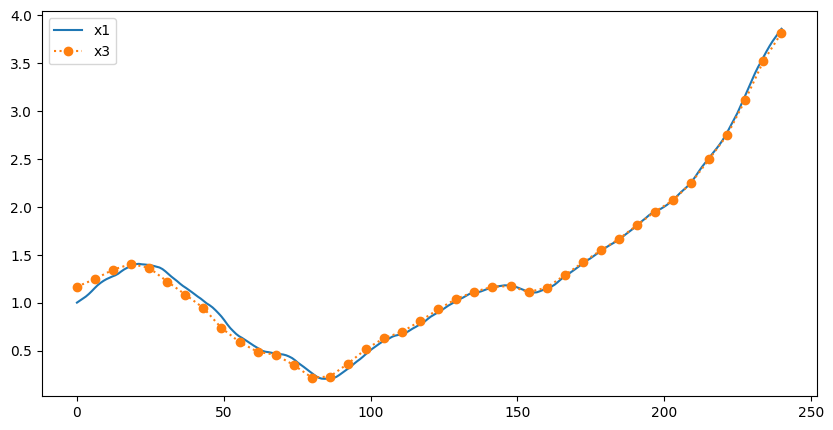

In [63]:
t1 = np.linspace(0,240,L1)
t2 = np.linspace(0,240,L2)
t3 = np.linspace(0,240,L3)
t4 = np.linspace(0,240,L4)
t5 = np.linspace(0,240,L5)
plt.figure(figsize=(10,5),dpi=100)
# 状态
plt.plot(t1,x1[0,:-1],label='x1')
# plt.plot(t2,x2[0],'o:',label='x2')
plt.plot(t3,x3[0],'o:',label='x3')
# plt.plot(t4,x4[0],'o:',label='x4')
# plt.plot(t5,x5[0],'o:',label='x5')
# 量测
# plt.plot(t1,zs1,label='zs1')
# plt.plot(t2,zs2,'o:',label='zs2')
# plt.plot(t3,zs3,'o:',label='zs3')
# plt.plot(t4,zs4,'o:',label='zs4')
# plt.plot(t5,zs5,'o:',label='zs5')
plt.legend()

In [4]:
def fusion_block(zs1, zs2, zs3, A_, C_, R_, B_, Q_, data_size1, data_size2):
    xs = []
    # 建立Kalman滤波模型
#     fk = KalmanFilter(dim_x = 10, dim_z = 10)
    fk = Kalman(dim_x = 20, dim_z = 10)
    fk.x = np.array([1,0.2]*10)
    fk.B = B_
    fk.F = A_
    fk.H = C_
    fk.P = .01
    fk.R = R_
    fk.Q = Q_
#     print(fk.x.shape)
    for j in range(int(len(zs1)/(data_size1*data_size2))):
#         x_ = x0[0,data_size*j:data_size*(j+1)]
#         if(j==0):
#             z_ = np.concatenate((zs1[j:(j+1)].reshape(1,),zs0[data_size*j:data_size*(j+1)]), axis=0)
#         else:
        z_ = np.concatenate((zs3[j:(j+1)].reshape(1,),zs2[data_size2*j:data_size2*(j+1)],
                             zs1[data_size2*data_size1*j:data_size2*data_size1*(j+1)]), axis=0)
        fk.predict()
        fk.update(z_)
        xs.append(fk.x)
    xs = asarray(xs)
    return xs
def Withdraw_x(xs,L):
    X_e0 = []
    X_e1 = []
    for i in range(int(L/(3*2))):
        for j in range(8,20,2):
            X_e0.append(xs[i,j])
        for j in range(9,20,2):
            X_e1.append(xs[i,j])
    X_e0 = asarray(X_e0)
    X_e1 = asarray(X_e1)
    return np.concatenate((X_e0.reshape(L,1),X_e0.reshape(L,1)),axis=1)

In [5]:
# x3(k)
# x2(3k-1),x2(3k),x2(3k+1),x2(3k+2)
# x1(6k-2),x1(6k-1),x1(6k),x1(6k+1),x1(6k+2),x1(6k+3),x1(6k+4),x1(6k+5),x1(6k+6),x1(6k+7)

# X_(k) = col{x1(6k-2),x1(6k-1),x1(6k),x1(6k+1),x1(6k+2),x1(6k+3),x1(6k+4),x1(6k+5),x1(6k+6),x1(6k+7)}
# W_(k) = col{w(6k),w(6k+1),w(6k+2),w(6k+3),w(6k+4),w(6k+5)}
# Z_(k) = col{zs3,zs2,zs2,zs2,zs1,zs1,zs1,zs1,zs1,zs1}
# X_.shape = 20x1
# A_.shape = 20x20
# C_.shape = 10x20
# R_.shape = 10x10
# B_.shape = 20x6
coeff = 1/2
# a1 = 0.6830127*coeff
# a2 = 1.1830127*coeff
# a3 = 0.3169873*coeff
# a4 = -0.1830127*coeff
a4 = 0.6830127*coeff
a3 = 1.1830127*coeff
a2 = 0.3169873*coeff
a1 = -0.1830127*coeff
# a1 = 0
# a2 = 1
# a3 = 0
# a4 = 0
# haar = np.sqrt(2)/2
zero = np.array([[0,0],[0,0]])
zero_r = np.array([[0],[0]])
one = np.array([[1,0],[0,1]])

# A_ = np.array([[0.,0.,0.,0.,0.,0.,1.,0.,0.,0.],
#               [0.,0.,0.,0.,0.,0.,0.,1.,0.,0.],
#               [0.,0.,0.,0.,0.,0.,0.,0.,1.,0.],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,1.],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,F[0][0]],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,2)[0][0]],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,3)[0][0]],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,4)[0][0]],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,5)[0][0]],
#               [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,6)[0][0]]])

aa1 = np.concatenate((zero,zero,zero,zero,zero,zero,one,zero,zero,zero),axis=1)
aa2 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,one,zero,zero),axis=1)
aa3 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,one,zero),axis=1)
aa4 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,one),axis=1)
aa5 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,F),axis=1)
aa6 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,matrixPow(F,2)),axis=1)
aa7 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,matrixPow(F,3)),axis=1)
aa8 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,matrixPow(F,4)),axis=1)
aa9 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,matrixPow(F,5)),axis=1)
aa10 = np.concatenate((zero,zero,zero,zero,zero,zero,zero,zero,zero,matrixPow(F,6)),axis=1)
A_ = np.concatenate((aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10),axis=0)

C_ = np.array([[a1*a1,0,a1*a2,0,a1*a3+a2*a1,0,a1*a4+a2*a2,0,a2*a3+a3*a1,0,
                a2*a4+a3*a2,0,a3*a3+a4*a1,0,a3*a4+a4*a2,0,a4*a3,0,a4*a4,0],
              [0,0,0,0,a1,0, a2,0, a3,0, a4,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,a1,0, a2,0, a3,0, a4,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,a1,0, a2,0, a3,0, a4,0],
              [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]])


R_ = np.diag([r3[0][0],r2[0][0],r2[0][0],r2[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0]])

# B_ = np.array([[0,0,0,0,0,0],
#                [0,0,0,0,0,0],
#                [0,0,0,0,0,0],
#                [0,0,0,0,0,0],
#                [b[0][0],0,0,0,0,0],
#                [(F@b)[0][0],b[0][0],0,0,0,0],
#                [(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0,0],
#                [(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0],
#                [(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],
#                    (F@b)[0][0],b[0][0],0],
#                [(matrixPow(F,5)@b)[0][0],(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],
#                    (matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0]]])

bb1 = np.concatenate((zero_r,zero_r,zero_r,zero_r,zero_r,zero_r),axis=1)
bb2 = np.concatenate((zero_r,zero_r,zero_r,zero_r,zero_r,zero_r),axis=1)
bb3 = np.concatenate((zero_r,zero_r,zero_r,zero_r,zero_r,zero_r),axis=1)
bb4 = np.concatenate((zero_r,zero_r,zero_r,zero_r,zero_r,zero_r),axis=1)
bb5 = np.concatenate((B,zero_r,zero_r,zero_r,zero_r,zero_r),axis=1)
bb6 = np.concatenate((F@B,B,zero_r,zero_r,zero_r,zero_r),axis=1)
bb7 = np.concatenate((matrixPow(F,2)@B,F@B,B,zero_r,zero_r,zero_r),axis=1)
bb8 = np.concatenate((matrixPow(F,3)@B,matrixPow(F,2)@B,F@B,B,zero_r,zero_r),axis=1)
bb9 = np.concatenate((matrixPow(F,4)@B,matrixPow(F,3)@B,matrixPow(F,2)@B,F@B,B,zero_r),axis=1)
bb10 = np.concatenate((matrixPow(F,5)@B,matrixPow(F,4)@B,matrixPow(F,3)@B,matrixPow(F,2)@B,F@B,B),axis=1)
B_ = np.concatenate((bb1,bb2,bb3,bb4,bb5,bb6,bb7,bb8,bb9,bb10),axis=0)

Q_ = np.diag([Q[0][0]]*6)

In [251]:
xs = fusion_block(zs1, zs2, zs3, A_, C_, R_, B_, Q_, 2, 3)

DWT_RMS0: 0.087


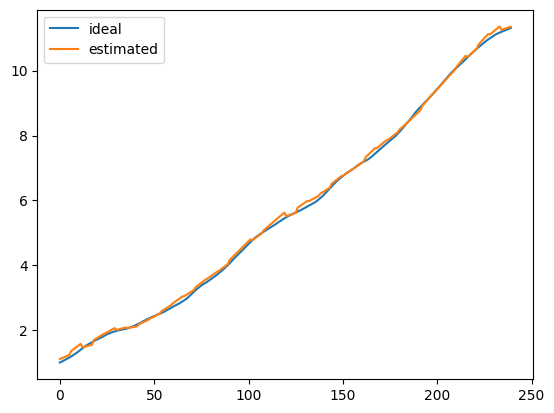

In [252]:
X_e0 = Withdraw_x(xs,L1)
nom0 = x1[0,:-1]
res0 = nom0 - X_e0[:,0]
rms_dev0 = np.sqrt(np.sum(np.square(res0) / res0.shape[0]))
print('DWT_RMS0: {:.3f}'.format (rms_dev0))
plt.plot(x1[0,:-1],label='ideal')
plt.plot(X_e0[:,0],label='estimated')
plt.legend()

## 非整数倍部分

In [6]:
def network_fusion(zs4, zs5, x1, n4, n5, model, L):
    x_hat = []
    Det4 = []
    Det5 = []
    h0_lstm = torch.zeros(1, hidden_dim)
    c0_lstm = torch.zeros(1, hidden_dim)
    # 数据归一化
    (X4,X5,Y1,C) = normalization_2(zs4,zs5,x1[0])
    for k in range(int(len(x1[0]))-1):
        k4 = int(k*n4)
        det4 = k - (k4/n4)
        k5 = int(k*n5)
        det5 = k - (k5/n5)

        M = np.concatenate((X4[0][k4].reshape(1,),X5[0][k5].reshape(1,)), axis=0).reshape(1,2)
        N = Y1[0,k].reshape(1,1)
        x = torch.from_numpy(M).type(dtype)
        y = torch.from_numpy(N).type(dtype)
        # 前向传播
        model.eval()
        if L:
            y_pred = model(x)
        else:
            y_pred,h0_lstm,c0_lstm = model(x,h0_lstm,c0_lstm)
        
        x_hat.append((reverse_1(y_pred.reshape(1,1),C).detach().numpy()))
        Det4.append(det4)
        Det5.append(det5)
    x_hat = np.array(x_hat)
    return x_hat, Det4, Det5

In [7]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, num_layers = 1, output_dim=1):
        super(LSTM, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
 
    def forward(self, x, h0, c0):
#         x = x.unsqueeze(1)
 
        h0_lstm = torch.zeros(1, self.hidden_dim).to(x.device)
        c0_lstm = torch.zeros(1, self.hidden_dim).to(x.device)
#         print(h0_lstm.shape)
        out, _ = self.lstm(x, (h0, c0))
#         print(out.shape)
        out = out[-1, :]
#         print(out.shape)
        out = self.fc(out)
#         out = torch.sum(out,axis=0)
        return out,h0,c0
class LSTM_GRU(torch.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, num_layers=2, output_dim=1, pre_len= 1, dropout = 0.01):
        super(LSTM_GRU, self).__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.pre_len = pre_len
        self.hidden_dim = hidden_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.gru = torch.nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linearOut = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        hidden = ((torch.zeros(1, self.hidden_dim)),
                  (torch.zeros(1, self.hidden_dim)))
        x, lstm_h = self.lstm(x, hidden)

        x = self.dropout(x)
        x = torch.tanh(x)
#         x = x.permute(0, 2, 1)
        x, gru_ = self.gru(x)
        x = self.dropout(x)
        x = torch.tanh(x)
#         x = x.permute(0, 2, 1)
        x = self.linearOut(x)
#         print(x.shape)
#         x = x[:, -self.pre_len:, :]

        return x

In [445]:
# LSTM
hidden_dim = 10
h0_lstm = torch.zeros(1, hidden_dim)
c0_lstm = torch.zeros(1, hidden_dim)
model = LSTM(input_dim=2, hidden_dim=10, num_layers = 1, output_dim=1)

In [513]:
# LSTM_GRU
model = LSTM_GRU(input_dim=2, num_layers = 1, output_dim=1)

In [ ]:
# BP
model = NeuralNetwork1(input_size=2, num_classes=1)

 51%|████████████████████████████████▋                               | 51/100 [00:05<00:05,  8.50it/s]

Epoch:50,loss:0.011719822883605957


100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.69it/s]

Epoch:100,loss:0.005243122577667236


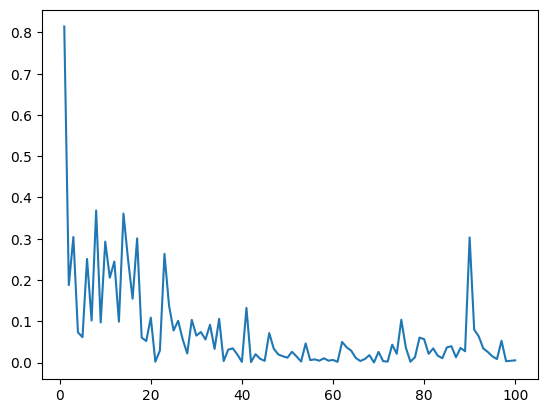

In [514]:
# 训练
Epoch=[]
Loss=[]
# model = NeuralNetwork1(input_size=2, num_classes=1)
# x = torch.rand(10,6)
# print(model(x).shape) 
# Output : torch.Size([64, 10])
dtype = torch.FloatTensor
learning_rate = 0.0001
# batch_size = 64
num_epochs = 100
# 损失和优化器
criterion = torch.nn.L1Loss()
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(params= model.parameters(), lr=learning_rate, weight_decay=1e-3)

# 数据归一化
# (X1,X4,X5,Y1,C) = normalization_3(zs1,zs4,zs5,x1[0])
# 训练
for epoch in tqdm(range(1,num_epochs+1)):
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    (X1,X4,X5,Y1,C) = normalization_3(zs1,zs4,zs5,x1[0])
    k1 = 0
    k2 = 0
#     det1 = 0
#     det2 = 0
    for k in range(L1):
        k4 = int(k*n4)
#         det4 = k - (k4/n4)
        k5 = int(k*n5)
#         det5 = k - (k5/n5)
#         M = np.concatenate((X1[0][k1].reshape(1,),X2[0][k2].reshape(1,),
#                             np.array(det1).reshape(1,),np.array(det2).reshape(1,)), axis=0).reshape(1,4)
#         M = np.concatenate((X1[0][k1].reshape(1,),X2[0][k2].reshape(1,)), axis=0).reshape(1,2)
        M = np.concatenate((X4[0][k4].reshape(1,),X5[0][k5].reshape(1,)), axis=0).reshape(1,2)
        N = Y1[0,k].reshape(1,1)
        x = torch.from_numpy(M).type(dtype)
        y = torch.from_numpy(N).type(dtype)
        # 前向传播
        scores = model(x)
#         scores,h0_lstm,c0_lstm = model(x,h0_lstm,c0_lstm)
        loss = criterion(scores.reshape(1,1), y)
        optimizer.zero_grad()
#         l += loss.data
        loss.backward()
        # 参数微调
        optimizer.step()
    Epoch.append(epoch)
    Loss.append(loss.data)
    if epoch%50==0:
        print("Epoch:{},loss:{}".format(epoch,loss))

    time.sleep(0.01)
Epoch=np.array(Epoch)
Loss=np.array(Loss)
plt.plot(Epoch,Loss)
plt.show()

In [515]:
# 保存权重
# torch.save(model.state_dict(), 'save_model_non-interget.pth')
# torch.save(model.state_dict(), 'save_model_non-interget_LSTM.pth')
torch.save(model.state_dict(), 'save_model_non-interget_GRU.pth')

BP: 0.265;time = 0.01622
LSTM: 
LSTM_GRU:;time = 0.05455

代码执行时间为：0.053978919982910156秒
NeuralNetwork_RMS: 0.257


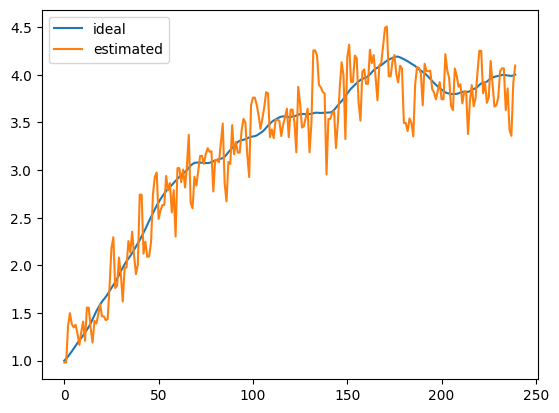

In [504]:
x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
start_time = time.time()
x_hat, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model, 1)
end_time = time.time()
run_time = end_time - start_time
print("代码执行时间为：%s秒" % run_time)
# 画图
nom = x1[0,:-1]
res = nom.reshape(L1,1) - np.array(x_hat).reshape(L1,1)
std_dev = np.sqrt(np.sum(np.square(res) / res.shape[0]))
print('NeuralNetwork_RMS: {:.3f}'.format(std_dev))
plt.plot(x1[0,:-1],label='ideal')
plt.plot(x_hat.reshape(L1,),label='estimated')
plt.legend()

## 50步蒙特卡洛仿真非整数倍部分—不同网络效果对比

In [9]:
hidden_dim = 10
dtype = torch.FloatTensor
x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
# BP
model_BP = NeuralNetwork1(input_size=2, num_classes=1)
model_BP.load_state_dict(torch.load('save_model_non-interget.pth'))
start_time = time.time()
for i in range(50):
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    x_hat_BP, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_BP, 1)
end_time = time.time()
run_time = end_time - start_time
print("BP代码执行时间为：%s秒" % run_time)
# LSTM
hidden_dim = 10
h0_lstm = torch.zeros(1, hidden_dim)
c0_lstm = torch.zeros(1, hidden_dim)
model_LSTM = LSTM(input_dim=2, hidden_dim=10, num_layers = 1, output_dim=1)
model_LSTM.load_state_dict(torch.load('save_model_non-interget_LSTM.pth'))
start_time = time.time()
for i in range(50):
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    x_hat_LSTM, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_LSTM, 0)
end_time = time.time()
run_time = end_time - start_time
print("LSTM代码执行时间为：%s秒" % run_time)
# LSTM_GRU
model_GRU = LSTM_GRU(input_dim=2, num_layers = 1, output_dim=1)
model_GRU.load_state_dict(torch.load('save_model_non-interget_GRU.pth'))
start_time = time.time()
for i in range(50):
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    x_hat_GRU, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_GRU, 1)
end_time = time.time()
run_time = end_time - start_time
print("GRU代码执行时间为：%s秒" % run_time)

BP代码执行时间为：0.4968991279602051秒
LSTM代码执行时间为：0.9453270435333252秒
GRU代码执行时间为：1.503108024597168秒


BP代码执行时间为：0.029742717742919922秒
LSTM代码执行时间为：0.028175830841064453秒
GRU代码执行时间为：0.030418872833251953秒
BP_average_RMS: 0.301
LSTM_average_RMS: 0.310
GRU_average_RMS: 0.369


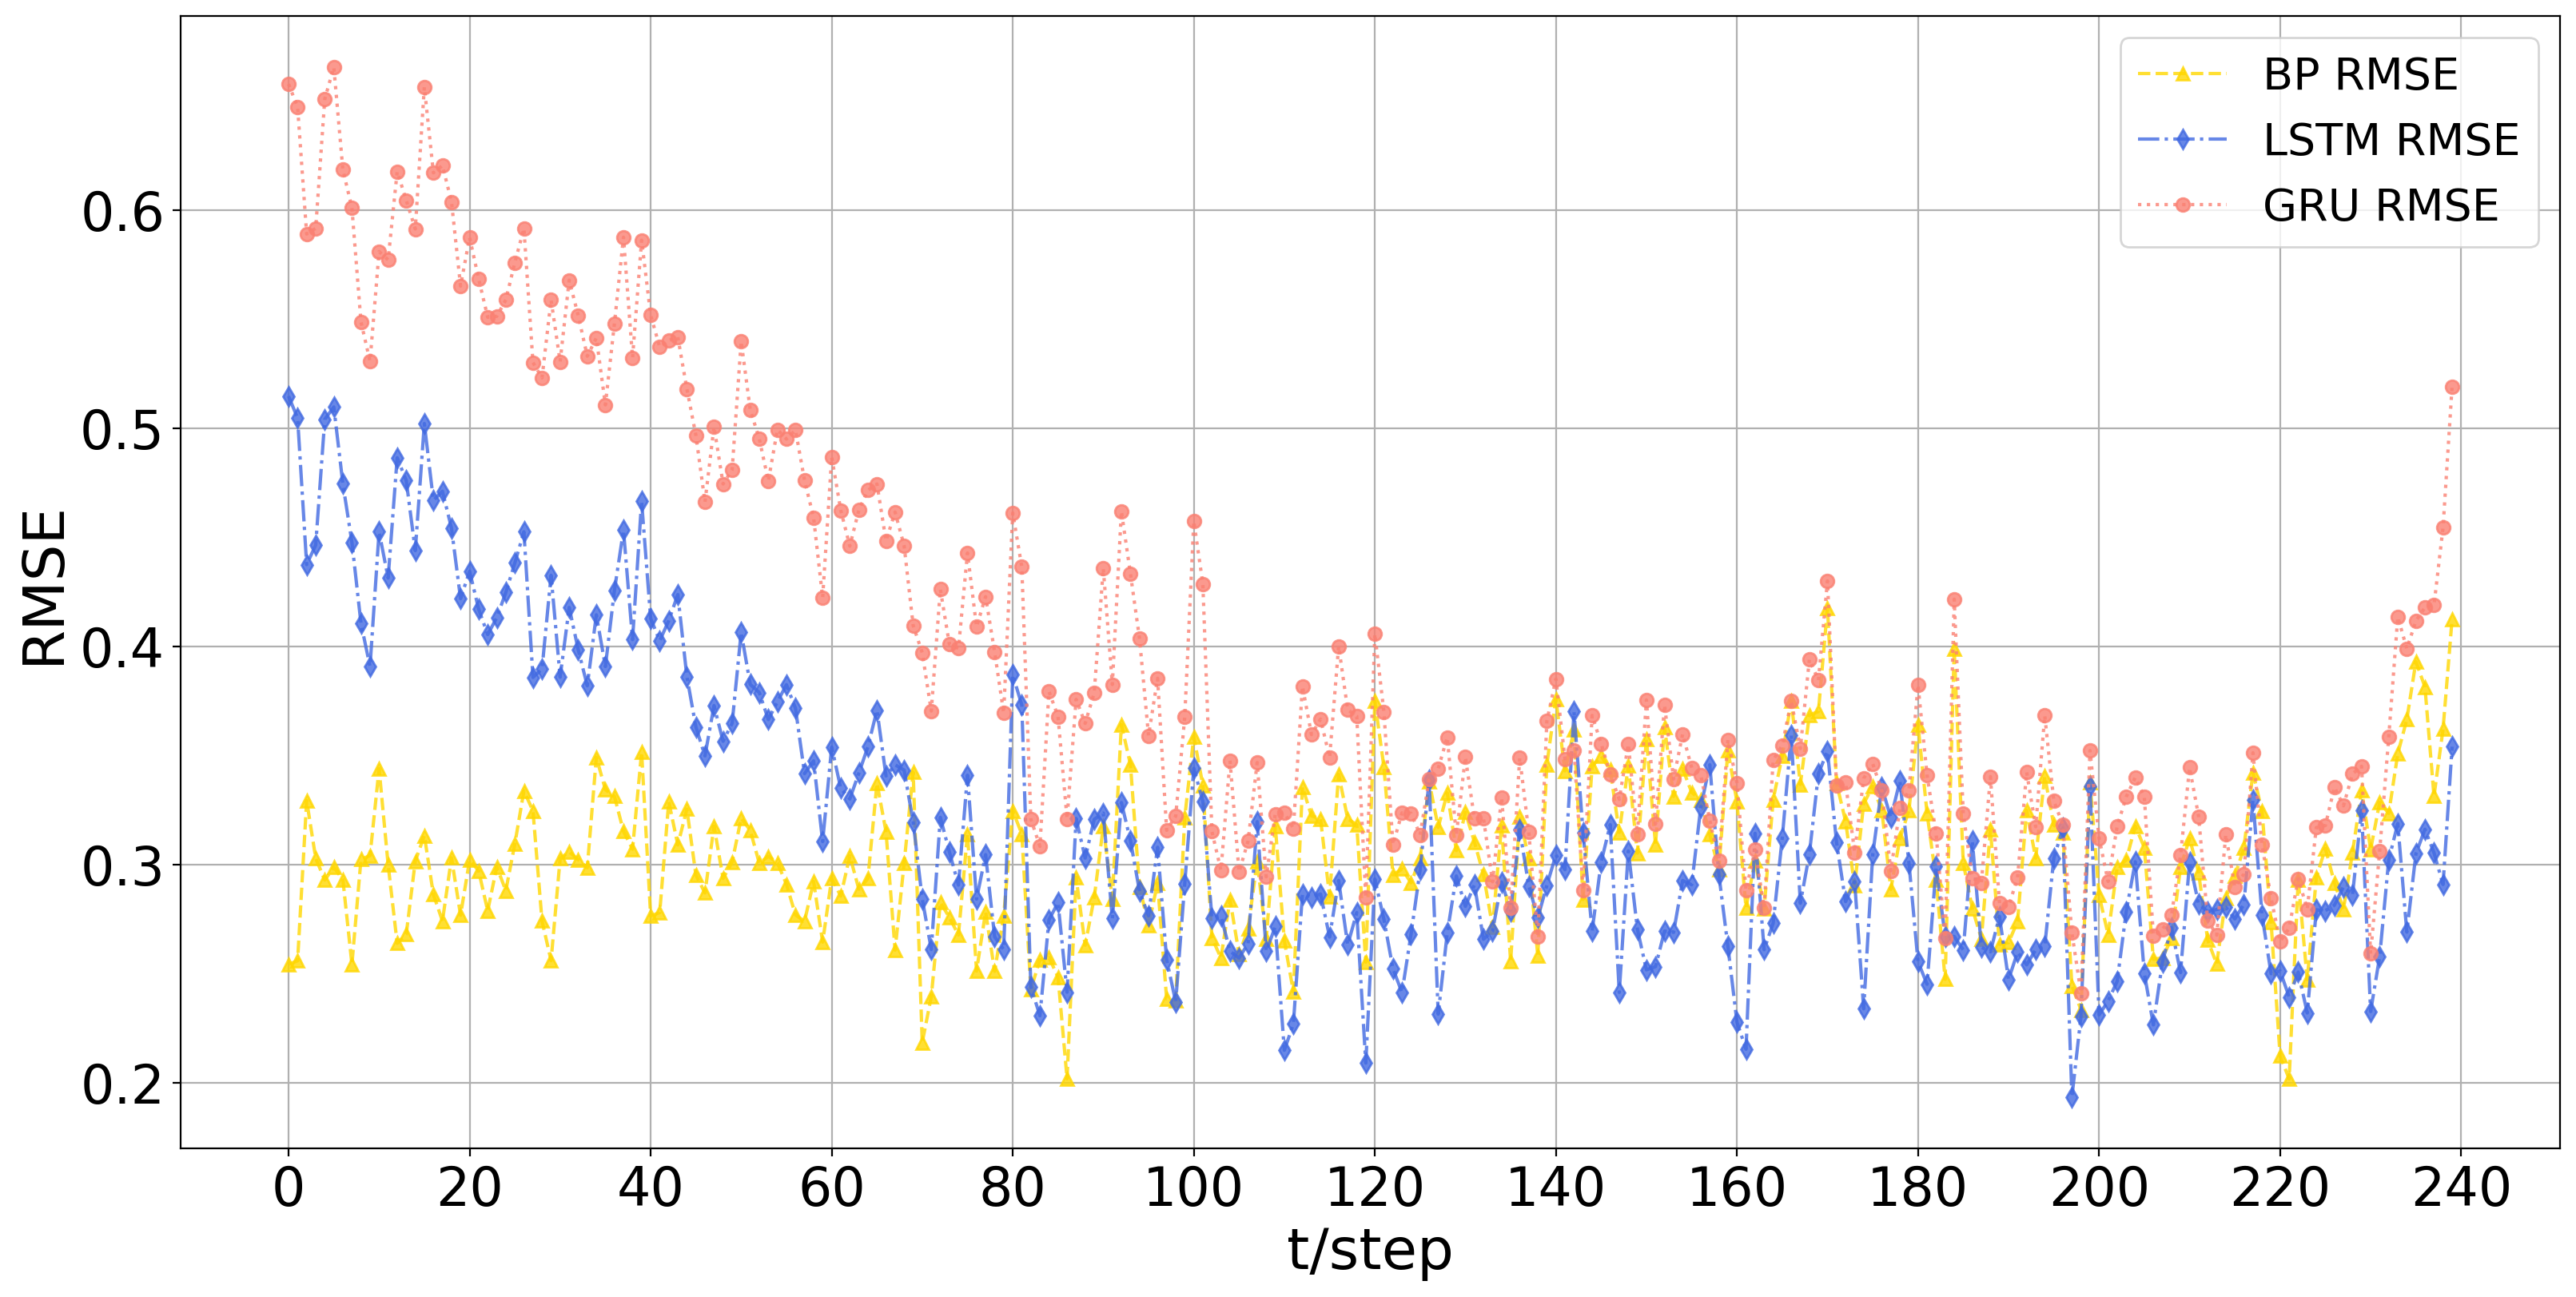

In [10]:
hidden_dim = 10
dtype = torch.FloatTensor
x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
# BP
model_BP = NeuralNetwork1(input_size=2, num_classes=1)
model_BP.load_state_dict(torch.load('save_model_non-interget.pth'))
start_time = time.time()
x_hat_BP, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_BP, 1)
end_time = time.time()
run_time = end_time - start_time
print("BP代码执行时间为：%s秒" % run_time)
# LSTM
hidden_dim = 10
h0_lstm = torch.zeros(1, hidden_dim)
c0_lstm = torch.zeros(1, hidden_dim)
model_LSTM = LSTM(input_dim=2, hidden_dim=10, num_layers = 1, output_dim=1)
model_LSTM.load_state_dict(torch.load('save_model_non-interget_LSTM.pth'))
start_time = time.time()
x_hat_LSTM, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_LSTM, 0)
end_time = time.time()
run_time = end_time - start_time
print("LSTM代码执行时间为：%s秒" % run_time)
# LSTM_GRU
model_GRU = LSTM_GRU(input_dim=2, num_layers = 1, output_dim=1)
model_GRU.load_state_dict(torch.load('save_model_non-interget_GRU.pth'))
start_time = time.time()
x_hat_GRU, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_GRU, 1)
end_time = time.time()
run_time = end_time - start_time
print("GRU代码执行时间为：%s秒" % run_time)

# 计算误差
RMS_BP = np.zeros((L1,1))
RMS_LSTM = np.zeros((L1,1))
RMS_GRU = np.zeros((L1,1))
rms1 = []
rms2 = []
rms3 = []
for i in range(50):
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    nom = (x1[0,:-1]).reshape(L1,1)
    x_hat_BP, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_BP, 1)
    x_hat_LSTM, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_LSTM, 0)
    x_hat_GRU, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5, model_GRU, 1)
    res1 = nom - np.array(x_hat_BP).reshape(L1,1)
    res2 = nom - np.array(x_hat_LSTM).reshape(L1,1)
    res3 = nom - np.array(x_hat_GRU).reshape(L1,1)
    rms_dev1 = np.sqrt(np.sum(np.square(res1) / res1.shape[0]))
    rms_dev2 = np.sqrt(np.sum(np.square(res2) / res2.shape[0]))
    rms_dev3 = np.sqrt(np.sum(np.square(res3) / res3.shape[0]))
    rms1.append(rms_dev1)
    rms2.append(rms_dev2)
    rms3.append(rms_dev3)
    RMS_BP += np.square(res1)
    RMS_LSTM += np.square(res2)
    RMS_GRU += np.square(res3)
rms1 = asarray(rms1)
rms2 = asarray(rms2)
rms3 = asarray(rms3)
std_dev1 = np.sum(rms1)/50
std_dev2 = np.sum(rms2)/50
std_dev3 = np.sum(rms3)/50
RMS_BP = np.sqrt(RMS_BP/50)
RMS_LSTM = np.sqrt(RMS_LSTM/50)
RMS_GRU = np.sqrt(RMS_GRU/50)

print('BP_average_RMS: {:.3f}'.format(std_dev1))
print('LSTM_average_RMS: {:.3f}'.format(std_dev2))
print('GRU_average_RMS: {:.3f}'.format(std_dev3))

# 画图
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=200, constrained_layout = True)

axes.plot(RMS_BP.reshape(L1,1),color='gold',marker='^',linestyle='--',
             alpha=0.8,label='BP RMSE')
axes.plot(RMS_LSTM.reshape(L1,1),color='royalblue',marker='d',linestyle='-.',
             alpha=0.8,label='LSTM RMSE')
axes.plot(RMS_GRU.reshape(L1,1),color='salmon',marker='o',linestyle=':',
             alpha=0.8,label='GRU RMSE')
axes.grid(visible=True, axis='x')
axes.grid(visible=True, axis='y')

x_label = ["{}".format(i) for i in range(L1+20)]
axes.set_xticks(range(L1+20)[::20], x_label[::20], fontsize=24)
# axes[0].set_yticks(fontsize=14)
axes.tick_params(axis='y', labelsize=24)
# axes.set_ylim(0, 1)
axes.set_xlabel('t/step', fontsize=26)
axes.set_ylabel('RMSE', fontsize=26)
# axes.set_title('(b)', fontsize=30)
axes.legend(fontsize=20)

In [11]:
fig.savefig('./Comparison_of_different_network_RMSE.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


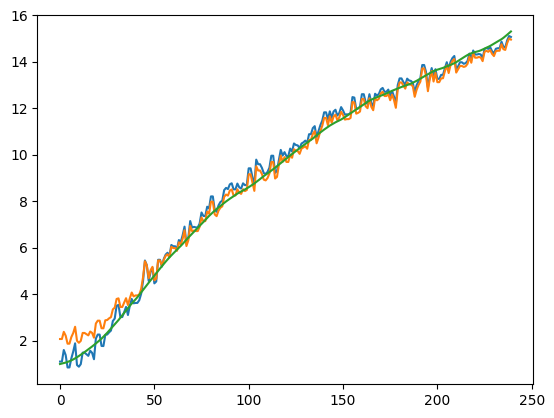

In [510]:
plt.plot(np.array(x_hat_BP).reshape(L1,1))
# plt.plot(np.array(x_hat_LSTM).reshape(L1,1))
plt.plot(np.array(x_hat_GRU).reshape(L1,1))
plt.plot(x1[0,:-1])
# plt.plot(res1)

## 整数倍和非整数倍融合

In [318]:
# 最小化函数
def fun(args):
    # 这里的 P 指待融合的数据
    P_1,P_2,y = args
    v = lambda x: np.abs(x[0]*(P_1) + x[1]*(P_2) - (y))
    return v
def con(args):
    # 约束条件 分为eq 和ineq
    # eq表示 函数结果等于0 ； ineq 表示 表达式大于等于0  
    x1min, x1max = args
    cons = ({'type': 'ineq', 'fun': lambda x: x[0] - x1min},\
            {'type': 'ineq', 'fun': lambda x: -x[0] + x1max},\
            {'type': 'ineq', 'fun': lambda x: x[1] - x1min},\
            {'type': 'ineq', 'fun': lambda x: -x[1] + x1max},\
            {'type': 'eq', 'fun': lambda x: x[0]+x[1]-1})
    return cons
def integral_fusion(Det4, Det5, X_e0, x_hat, x1):
    x_f = []

    for k in range(int(len(x1[0]))-1):
        d1 = np.array([Det4[k],Det5[k]]).reshape(1,2)
        D = torch.from_numpy(d1).type(dtype)
        # 前向传播
        omega = model2(D)
        y_pred = X_e0[k][0]*omega + (1-omega)*x_hat[k][0][0]
        x_f.append(y_pred.detach().numpy())

    x_f = np.array(x_f)
    return x_f

In [319]:
# 测试理想融合效果
# 生成信号
x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
# 小波融合
xs = fusion_block(zs1, zs2, zs3, A_, C_, R_, B_, Q_, 2, 3)
X_e0 = Withdraw_x(xs,L1)
# 神经网络融合
xs1, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5)

x_ = np.zeros((L1,1))
omega = np.zeros((L1,1))
for k in range(L1):
    args = (X_e0[k][0],x_hat[k][0][0],x1[0,k])
    args1 = (0,1)
    cons = con(args1) 
    x000 = np.asarray((0.5,0.5))
    res = minimize(fun(args), x000, method='SLSQP',constraints=cons)
    alpha = res.x
    omega[k] = alpha[0]
    x_[k] = alpha[0]*X_e0[k][0] + alpha[1]*xs1[k][0][0]

fusion_RMS0: 0.163
integer_RMS: 0.171
non-integer_RMS: 0.277


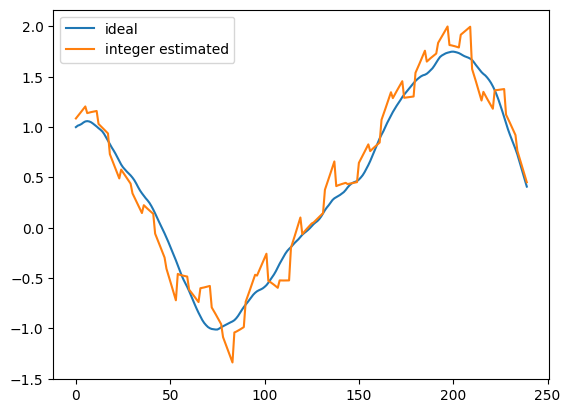

In [320]:
nom0 = x1[0,:-1]
res0 = nom0 - x_.reshape(L1,)
res1 = nom0 - X_e0[:,0]
res2 = nom0 - xs1[:,0,0]
rms_dev0 = np.sqrt(np.sum(np.square(res0) / res0.shape[0]))
rms_dev1 = np.sqrt(np.sum(np.square(res1) / res1.shape[0]))
rms_dev2 = np.sqrt(np.sum(np.square(res2) / res2.shape[0]))
print('fusion_RMS0: {:.3f}'.format (rms_dev0))
print('integer_RMS: {:.3f}'.format (rms_dev1))
print('non-integer_RMS: {:.3f}'.format (rms_dev2))
plt.plot(x1[0,:-1],label='ideal')
# plt.plot(x_,label='fusion estimated')
plt.plot(X_e0[:,0],label='integer estimated')
# plt.plot(xs1[:,0,0],label='non-integer estimated')
plt.legend()

In [276]:
# 生成信号
x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
# 小波融合
xs = fusion_block(zs1, zs2, zs3, A_, C_, R_, B_, Q_, 2, 3)
X_e0 = Withdraw_x(xs,L1)
# 神经网络融合
xs1, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5)

 50%|████████████████████████████████                                | 50/100 [00:22<00:22,  2.19it/s]

Epoch:50,loss:0.08681397253139822


100%|███████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]

Epoch:100,loss:0.24113434553146362


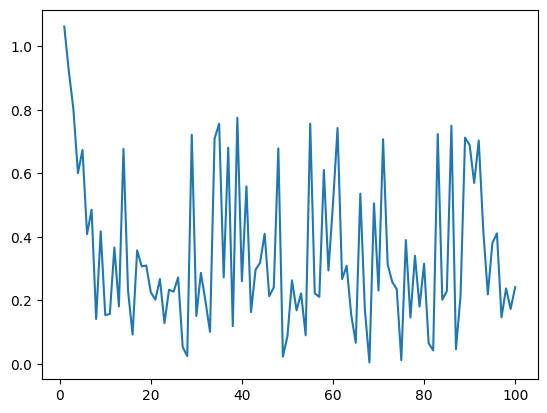

In [323]:
# 训练
Epoch2=[]
Loss2=[]
model2 = NeuralNetwork2(input_size=2, num_classes=1)
dtype = torch.FloatTensor
# input_size = 10
# num_classes = 6
learning_rate = 0.0001
# batch_size = 64
num_epochs = 100
# 损失和优化器
criterion2 = torch.nn.L1Loss()
optimizer2 = torch.optim.AdamW(params= model2.parameters(), lr=learning_rate, weight_decay=1e-3)
# 数据归一化
# (X1,X4,X5,Y1,C) = normalization_3(zs1,zs4,zs5,x1[0])
# 训练
for epoch in tqdm(range(1,num_epochs+1)):
    # 生成信号
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    # 小波融合
    xs = fusion_block(zs1, zs2, zs3, A_, C_, R_, B_, Q_, 2, 3)
    X_e0 = Withdraw_x(xs,L1)
    # 神经网络融合
    xs1, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5)
    for k in range(L1):
        k4 = int(k*n4)
        det4 = k - (k4/n4)
        k5 = int(k*n5)
        det5 = k - (k5/n5)

        d1 = np.array([Det4[k],Det5[k]]).reshape(1,2)
#         omega = x1[0,k].reshape(1,1)
        # 最优化
        args = (X_e0[k][0],xs1[k][0][0],x1[0,k])
        args1 = (0,1)
        cons = con(args1) 
        x000 = np.asarray((0.5,0.5))
        res = minimize(fun(args), x000, method='SLSQP',constraints=cons)
        alpha = res.x
        
        D = torch.from_numpy(d1).type(dtype)
        Omega = torch.tensor([[alpha[0]]])
        # 前向传播
        scores = model2(D)
        loss = criterion2(scores, Omega)
        optimizer2.zero_grad()
        loss.backward()
        # 参数微调
        optimizer2.step()
    Epoch2.append(epoch)
    Loss2.append(loss.data)
    if epoch%50==0:
        print("Epoch:{},loss:{}".format(epoch,loss))

    time.sleep(0.01)

Epoch2 = np.array(Epoch2)
Loss2 = np.array(Loss2)
plt.plot(Epoch2,Loss2)
plt.show()

In [328]:
# 保存权重
torch.save(model2.state_dict(), 'save_model_fusion.pth')

NeuralNetwork_Finally_RMS: 0.195


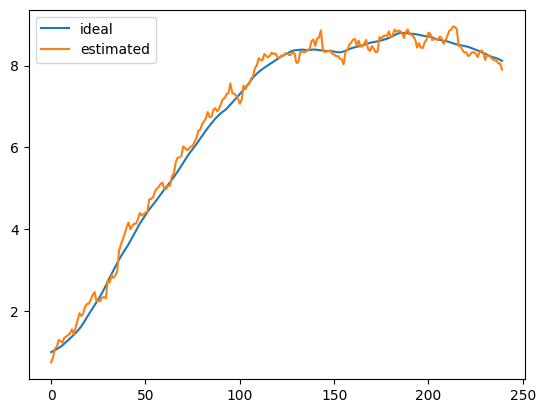

In [324]:
x_f = integral_fusion(Det4, Det5, X_e0, xs1, x1)
# 画图
nom = x1[0,:-1]
res_f = nom.reshape(L1,1) - np.array(x_f).reshape(L1,1)
std_dev_f = np.sqrt(np.sum(np.square(res_f) / res_f.shape[0]))
print('NeuralNetwork_Finally_RMS: {:.3f}'.format(std_dev_f))
plt.plot(x1[0,:-1],label='ideal')
plt.plot(x_f.reshape(L1,),label='estimated')
plt.legend()

## 200次蒙特卡洛仿真

In [ ]:
model = NeuralNetwork1(input_size=2, num_classes=1)
model2 = NeuralNetwork2(input_size=2, num_classes=1)
model.load_state_dict(torch.load('save_model_non-interget.pth')
model2.load_state_dict(torch.load('save_model_fusion.pth')

In [331]:
RMS1 = np.zeros(L1)
RMS2 = np.zeros(L1)
RMS3 = np.zeros(L1)
# RMS4 = np.zeros(L1)
rms1 = []
rms2 = []
rms3 = []
# rms4 = []
# 200次蒙特卡洛仿真
for i in range(200):
    # 生成信号
    x1,x2,x3,x4,x5,zs1,zs2,zs3,zs4,zs5 = generate_signal()
    # 整数倍部分融合
    xs = fusion_block(zs1, zs2, zs3, A_, C_, R_, B_, Q_, 2, 3)
    X_e0 = Withdraw_x(xs,L1)
    # 非整数倍融合
    xs1, Det4, Det5 = network_fusion(zs4, zs5, x1, n4, n5)
    # 整体融合
    xs_f = integral_fusion(Det4, Det5, X_e0, xs1, x1)
    # Haar融合
#     xs_haar = fusion_average(zs1, zs2, zs3, Aaa, Ccc, Rrr, Bbb, Qq_, 2, 3)
    # 计算RMS
    res1 = x1[0,:-1] - X_e0[:,0]
    res2 = x1[0,:-1] - xs1.reshape(L1,)
    res3 = x1[0,:-1] - xs_f.reshape(L1,)
#     res4 = x1[0,:-1] - xs_haar.reshape(L1,)
#     rms_dev1 = np.sqrt(np.square(res1) / res1.shape[0])
#     rms_dev2 = np.sqrt(np.square(res2) / res2.shape[0])
    rms_dev1 = np.sqrt(np.sum(np.square(res1) / res1.shape[0]))
    rms_dev2 = np.sqrt(np.sum(np.square(res2) / res2.shape[0]))
    rms_dev3 = np.sqrt(np.sum(np.square(res3) / res3.shape[0]))
#     rms_dev4 = np.sqrt(np.sum(np.square(res4) / res4.shape[0]))
    rms1.append(rms_dev1)
    rms2.append(rms_dev2)
    rms3.append(rms_dev3)
#     rms4.append(rms_dev4)
    RMS1 += np.square(res1)
    RMS2 += np.square(res2)
    RMS3 += np.square(res3)
#     RMS4 += np.square(res4)
rms1 = asarray(rms1)
rms2 = asarray(rms2)
rms3 = asarray(rms3)
# rms4 = asarray(rms4)
RMS1 = np.sqrt(RMS1/200)
RMS2 = np.sqrt(RMS2/200)
RMS3 = np.sqrt(RMS3/200)
# RMS4 = np.sqrt(RMS4/200)

(<matplotlib.patches.Rectangle at 0x29a2ebfa0>,
 (<matplotlib.patches.ConnectionPatch at 0x29a2fb220>,
  <matplotlib.patches.ConnectionPatch at 0x29a2fbbb0>))

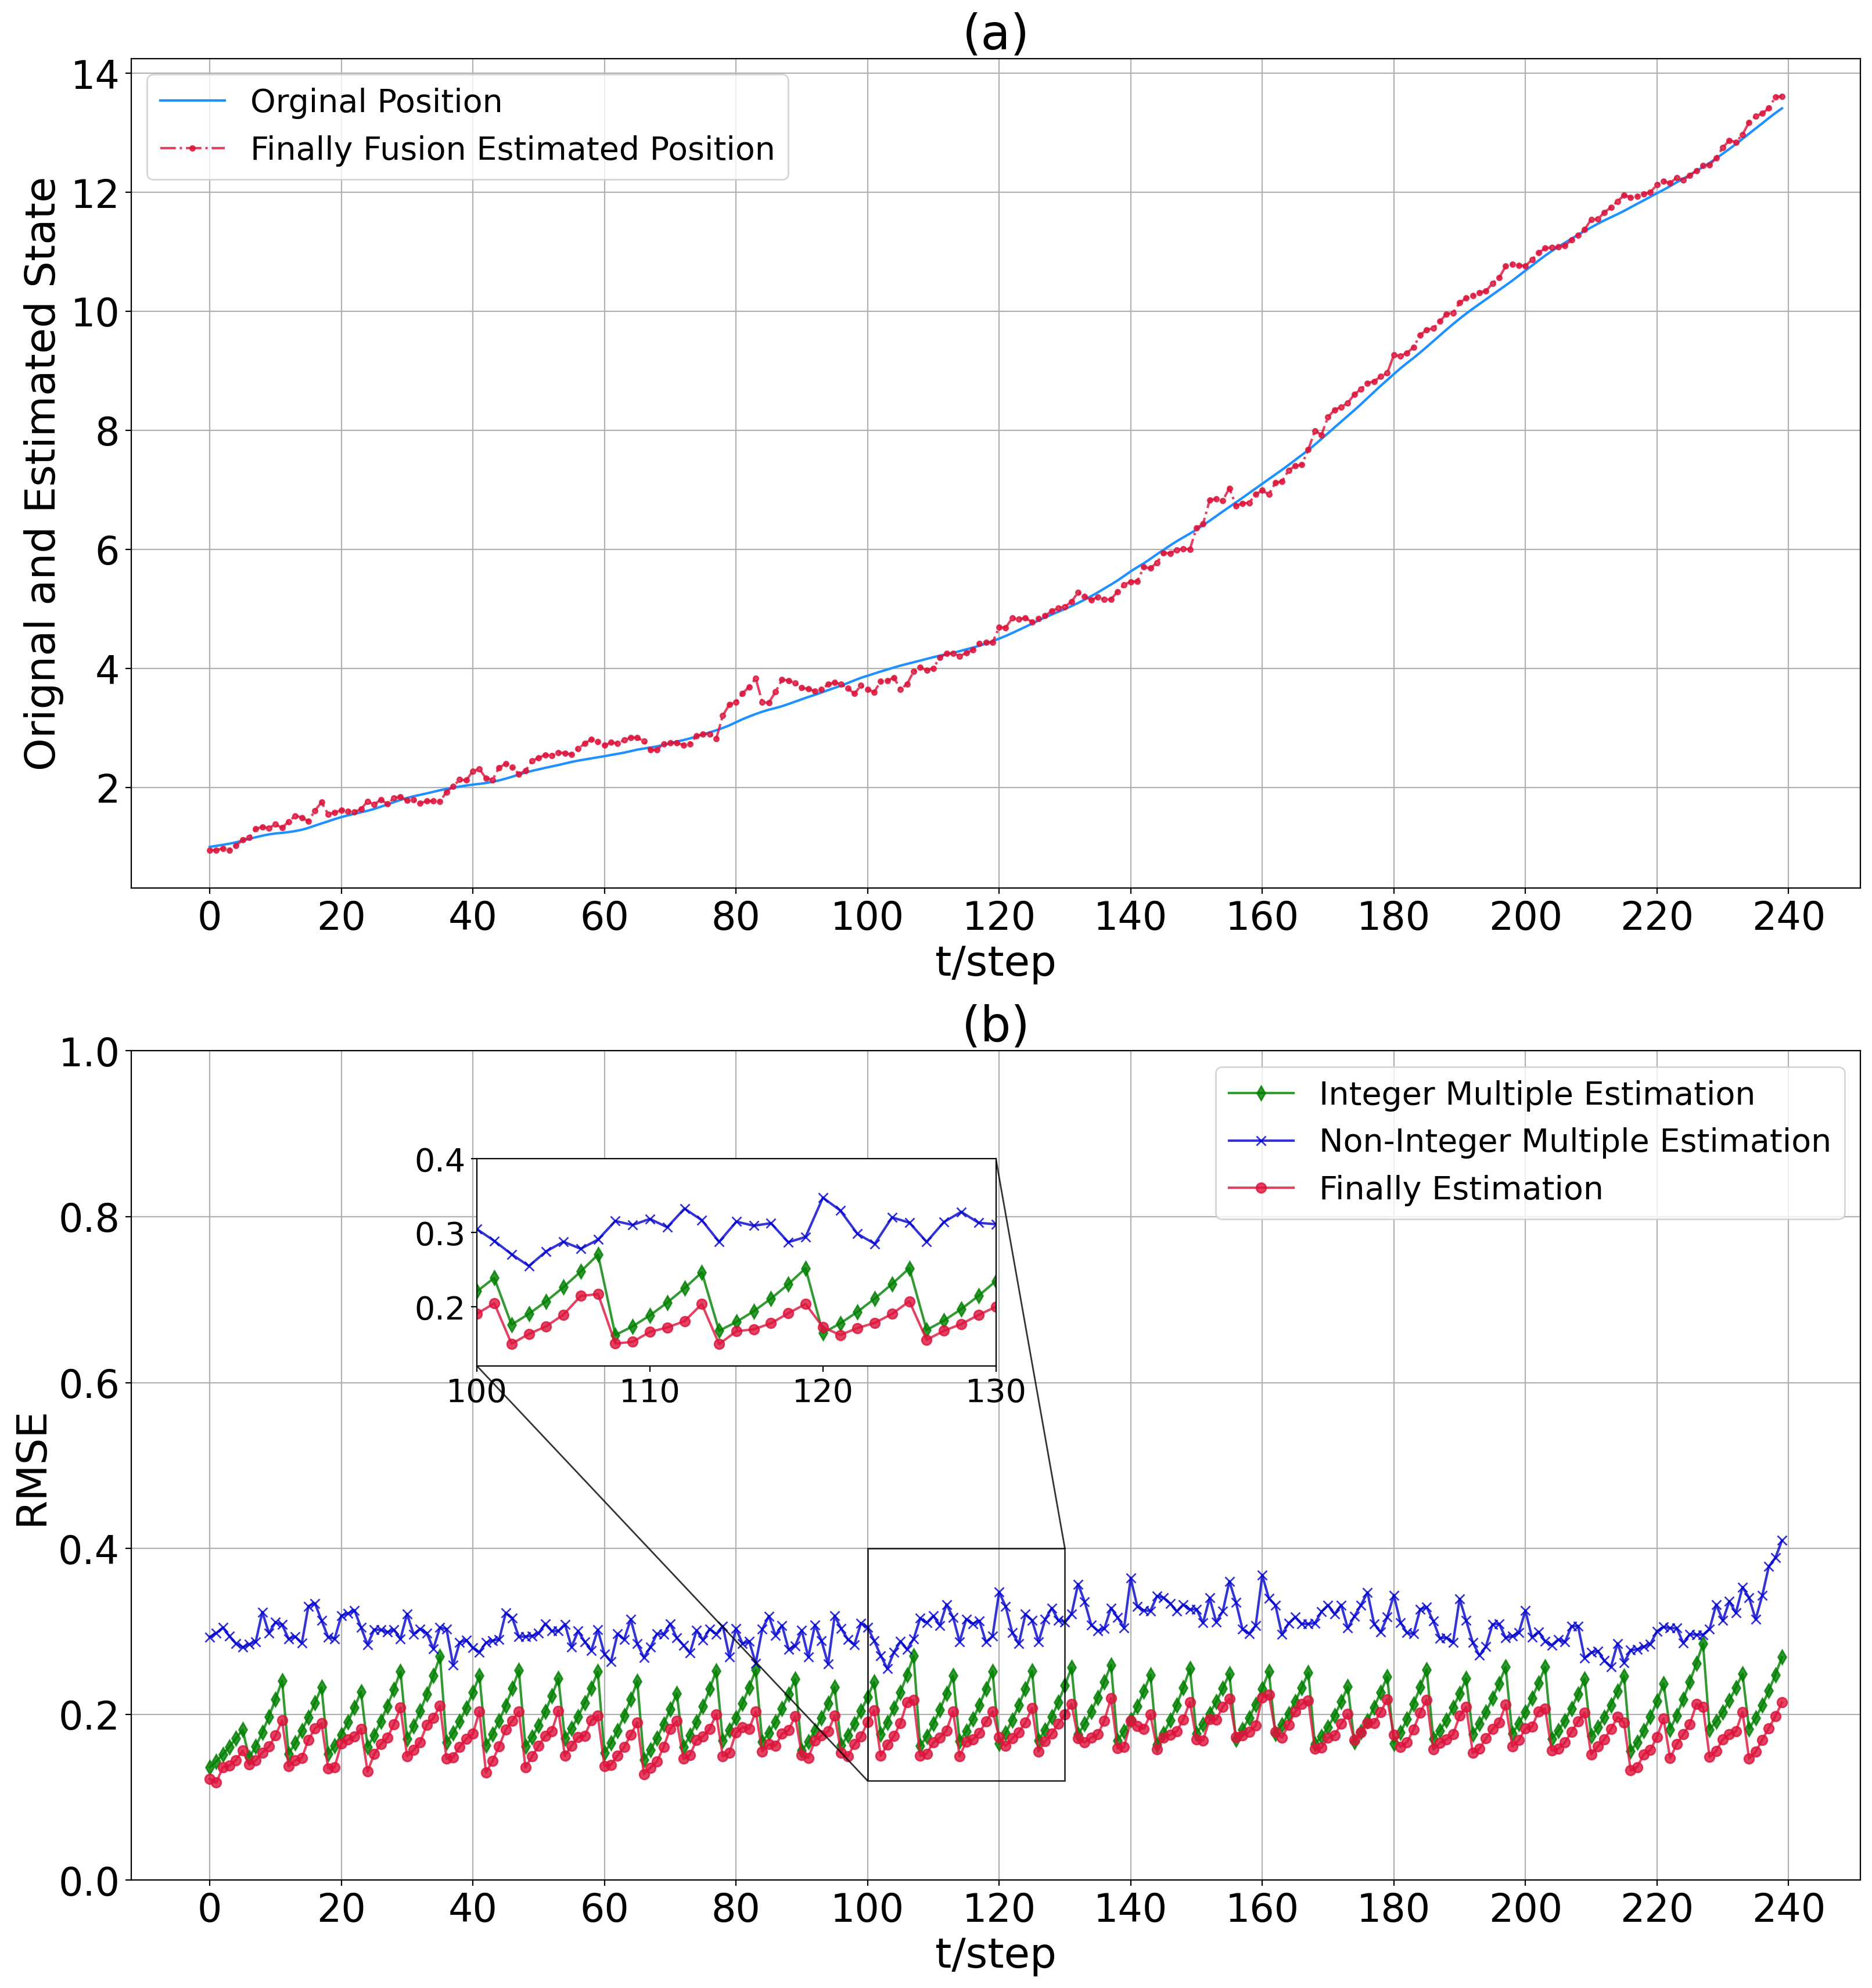

In [343]:
# 创建画布
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 17), dpi=200, constrained_layout = True)
# 图1
# plt.figure(figsize=(10,5),dpi=100)
axes[0].plot(x1[0,:-1],color='dodgerblue',label='Orginal Position')
# axes[0].plot(X_e0.reshape(L1,1),color='yellow',marker='.',linestyle='-.',alpha=0.8,label='Integer Fusion Estimation')
# axes[0].plot(xs1.reshape(L1,1),color='green',marker='.',linestyle='-.',alpha=0.8,label='Rational Fusion Estimation')
axes[0].plot(xs_f.reshape(L1,1),color='crimson',marker='.',linestyle='-.',alpha=0.8,label='Finally Fusion Estimated Position')
axes[0].grid(visible=True, axis='x')
axes[0].grid(visible=True, axis='y')

x_label = ["{}".format(i) for i in range(L1+20)]
axes[0].set_xticks(range(L1+20)[::20], x_label[::20], fontsize=24)
# axes[0].set_yticks(fontsize=14)
axes[0].tick_params(axis='y', labelsize=24)
axes[0].set_xlabel('t/step', fontsize=26)
axes[0].set_ylabel('Orignal and Estimated State', fontsize=26)
axes[0].set_title('(a)', fontsize=30)
axes[0].legend(fontsize=20)
# 图2
axes[1].plot(RMS1.reshape(L1,1),color='green',marker='d',linestyle='-',alpha=0.8,label='Integer Multiple Estimation')
axes[1].plot(RMS2.reshape(L1,1),color='mediumblue',marker='x',linestyle='-',alpha=0.8,label='Non-Integer Multiple Estimation')
axes[1].plot(RMS3.reshape(L1,1),color='crimson',marker='o',linestyle='-',alpha=0.8,label='Finally Estimation')
axes[1].grid(visible=True, axis='x')
axes[1].grid(visible=True, axis='y')

x_label = ["{}".format(i) for i in range(L1+20)]
axes[1].set_xticks(range(L1+20)[::20], x_label[::20], fontsize=24)
# axes[0].set_yticks(fontsize=14)
axes[1].tick_params(axis='y', labelsize=24)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('t/step', fontsize=26)
axes[1].set_ylabel('RMSE', fontsize=26)
axes[1].set_title('(b)', fontsize=30)
axes[1].legend(fontsize=20)
#画小图
axins = axes[1].inset_axes([0.2, 0.62, 0.3, 0.25])
axins.plot(RMS1.reshape(L1,1),color='green',marker='d',linestyle='-',alpha=0.8,label='Wavelet Estimation')
axins.plot(RMS2.reshape(L1,1),color='mediumblue',marker='x',linestyle='-',alpha=0.8,label='Yan\'s Estimation')
axins.plot(RMS3.reshape(L1,1),color='crimson',marker='o',linestyle='-',alpha=0.8,label='Average Estimation')
# axins.plot(RMS4.reshape(L1,1),color='yellow',marker='d',linestyle='dotted',alpha=0.8,label='Haar Estimation')
xz1, xz2, yz1, yz2 = 100, 130, 0.12, 0.4
axins.set_xlim(xz1, xz2)
axins.set_ylim(yz1, yz2)
#控制小图横纵坐标字体大小
axins.tick_params(axis='x', labelsize=20)
axins.tick_params(axis='y', labelsize=20)
# 显示投影线条
axes[1].indicate_inset_zoom(axins, edgecolor="black", alpha=0.8)

In [341]:
fig.savefig('./target_track_fusion.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
